In [1]:
import pandas as pd

In [3]:
df = pd.read_csv('all_data_to_train.csv')
df.head()

,age,credit_sum,credit_month,tariff_id,score_shk,monthly_income,credit_count,overdue_credit_count,marital_status,job_position,living_region,education,gender,target,train_test
0,48,59998.00,10,1.6,0.770249,30000,1,1,0.153104,0.189224,0.203165,0.139701,0.193810,0.0,1
1,28,10889.00,6,1.1,0.248514,43000,2,0,0.153104,0.189224,0.232049,0.139701,0.159967,0.0,1
2,32,10728.00,12,1.1,0.459589,23000,5,0,0.153104,0.166532,0.189394,0.205350,0.193810,0.0,1
3,27,12009.09,12,1.1,0.362536,17000,2,0,0.182172,0.166532,0.180113,0.139701,0.159967,0.0,1
4,45,16908.89,10,1.1,0.421385,25000,1,0,0.153104,0.166532,0.162420,0.205350,0.193810,0.0,1


In [4]:
X_train_scaled = df[df.train_test == 1].drop(['train_test'], axis =1)
X_test_scaled = df[df.train_test == 0].drop(['train_test'], axis =1)

y_train = df[df.train_test==1].target

In [5]:
X_train_scaled.shape, X_test_scaled.shape, y_train.shape

((170553, 14), (91824, 14), (170553,))

In Data Preprocessing:
- for encoding categorical variables used TargetEncoder, since OneHotencoder here would create so much extra dimensionality/columns.
- for scaling tried PowerTransformer, but performance of the model on it was not good, so scaling was not used.
- did not much transformation on analyzed data (outlier removal, grouping and aggregating living_region, etc.). Just experimented almost as it was initially.

Now let's build a model:

Model Building

In [5]:
X_train_scaled = X_train_scaled.drop('target', axis=1)

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train_scaled, y_train, test_size=0.15, random_state=42)

Logistic Regression with cross validation

In [102]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

lr_clf = LogisticRegression(random_state = 0, class_weight='balanced', max_iter=500, n_jobs=-1)
lr_clf.fit(X_train.values, y_train)
y_train_pred_lr=cross_val_predict(lr_clf, X_train.values, y_train, cv=3)

print('Accuracy on Training set:',cross_val_score(lr_clf, X_train.values,y_train, cv=3, scoring='accuracy'))
print('Accuracy on Test set:',cross_val_score(lr_clf, X_test.values,y_test, cv=3, scoring='accuracy'))

Accuracy on Training set: [0.66360401 0.5162552  0.67607557]
Accuracy on Test set: [0.69066604 0.6255863  0.63680075]


In [103]:
lr_clf.predict([[28,59998,10,1.6,0.77,30000,1,0,0.15,0.18,0.20,0.14,0.19]])

array([0.])

XGBoost

In [106]:
#Scale_pos_weight will take care of imbalanced data in the dataset
scale_pos_weight_value=y_train.value_counts().values.tolist()[0]/y_train.value_counts().values.tolist()[1]
from xgboost import XGBClassifier
XGB_clf = XGBClassifier(scale_pos_weight=scale_pos_weight_value)
XGB_clf.fit(X_train.values, y_train)
print('Accuracy on Training set:',cross_val_score(XGB_clf, X_train.values, y_train, cv=3, scoring='accuracy'))
print('Accuracy on Test set:',cross_val_score(XGB_clf, X_test.values, y_test, cv=3, scoring='accuracy'))

Accuracy on Training set: [0.68874679 0.68756079 0.69269292]
Accuracy on Test set: [0.68796904 0.68069887 0.6876979 ]


LightGBM without params

In [14]:
import lightgbm as lgb
LightGBM_clf=lgb.LGBMClassifier(scale_pos_weight=scale_pos_weight_value)
LightGBM_clf.fit(X_train, y_train)
print('Accuracy on Training set:',cross_val_score(LightGBM_clf, X_train, y_train, cv=3, scoring='accuracy'))
print('Accuracy on Test set:',cross_val_score(LightGBM_clf, X_test, y_test, cv=3, scoring='accuracy'))

Accuracy on Training set: [0.6815661  0.68327711 0.68762287]
Accuracy on Test set: [0.70110225 0.69594278 0.69567257]


In [42]:
#LightGBM_clf.predict([[28,59998,10,1.6,0.77,30000,1,0,0.15,0.18,0.20,0.14,0.19]])
LightGBM_clf.predict([[54,24990,12,1.1,0.41,40000,6,0,0.21,0.189,0.17,0.14,0.159]])

array([1.])

In [46]:
import pickle

with open('lgbm_model', 'wb') as f:
  pickle.dump(LightGBM_clf, f)

RandomForest

In [52]:
#class_weight = 'balanced' ensures that RandomForest works well on imbalanced datasets.
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators = 13, random_state = 0, n_jobs=-1)
rf_clf.fit(X_train.values, y_train.values)
print('Accuracy on Training set:',cross_val_score(rf_clf, X_train.values, y_train.values, cv=3, scoring='accuracy'))
print('Accuracy on Test set:',cross_val_score(rf_clf, X_test.values, y_test.values, cv=3, scoring='accuracy'))

Accuracy on Training set: [0.81588859 0.81619519 0.81607102]
Accuracy on Test set: [0.81121013 0.81414165 0.81259529]


In [53]:
rf_clf.predict([[54,24990,12,1.1,0.41,40000,6,0,0.21,0.189,0.17,0.14,0.159]])

array([0.])

Let's now try with RandomizedSearchCV to find best hyperparameters

In [54]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Most hyperparameters here are taken intuitively or randomly

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [ 10, 25, 50, 100]
min_samples_leaf = [1, 2, 4,10,20,30]
bootstrap = [True, False]

#Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [55]:
from sklearn.ensemble import RandomForestClassifier 
rf = RandomForestClassifier(class_weight="balanced") 
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 8, cv = 3, verbose=2, random_state=42, n_jobs = 1)

rf_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=100, n_estimators=200; total time=  51.4s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=100, n_estimators=200; total time=  49.4s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=100, n_estimators=200; total time=  48.6s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, n_estimators=200; total time=  31.1s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, n_estimators=200; total time=  31.1s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, n_estimators=200; total time=  31.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=100, n_esti

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 1000}

In [56]:
rf_random.predict([[54,24990,12,1.1,0.41,40000,6,0,0.21,0.189,0.17,0.14,0.159]])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([1.])

In [67]:
from sklearn.metrics import accuracy_score

y_hat = rf_random.predict(X_test)
acc = accuracy_score(y_test, y_hat)
print("Accuracy of RandomizedSearchCV RandomForest Classifier:", acc)

Accuracy of RandomizedSearchCV RandomForest Classifier: 0.8033459719344878


In [64]:
# Saving RandomizedSearchCV RandomForest Classifier model
with open('rf_random_model', 'wb') as f2:
  pickle.dump(rf_random, f2)

LightGBM with more params. 
This model will predict as continuous number between 0 and 1 giving us understanding how much the credit_target is close to 1

In [94]:
import lightgbm
train_data = lightgbm.Dataset(X_train, label=y_train)
test_data = lightgbm.Dataset(X_test, label=y_test)

parameters = {'objective': 'binary', # means result is [0,1]
              'metric': 'auc', # measures model's prediction irrespective of what classification threshold is chosen.
              'is_unbalance': 'true', # if some data is imbalanced (yes, we saw it on hitsograms in EDA part)
              'boosting': 'gbdt', # Gradient Boosting Decision Tree
              'num_leaves': 63, # numbers of leaves, chosen approximately
              'feature_fraction': 0.5, # for training next tree it will take 50% of previous tree
              'bagging_fraction': 0.5, # like feature_fraction, but this will randomly select part of data without resampling
              'bagging_freq': 20, # perform bagging at every 20 iterations
              'learning_rate': 0.01, # how much to change model per estimated error each time the model weights are updated
              'verbose': -1 # controls the level of LightGBM’s verbosity
             }

model_lgbm = lightgbm.train(parameters,
                            train_set = train_data,
                            valid_sets = test_data, # evaluation data
                            num_boost_round=3000,
                            early_stopping_rounds=150)

[1]	valid_0's auc: 0.611389
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's auc: 0.630615
[3]	valid_0's auc: 0.704283
[4]	valid_0's auc: 0.734886
[5]	valid_0's auc: 0.740912
[6]	valid_0's auc: 0.742451
[7]	valid_0's auc: 0.741272
[8]	valid_0's auc: 0.743719
[9]	valid_0's auc: 0.74712
[10]	valid_0's auc: 0.746414
[11]	valid_0's auc: 0.749449
[12]	valid_0's auc: 0.750574
[13]	valid_0's auc: 0.750953
[14]	valid_0's auc: 0.750886
[15]	valid_0's auc: 0.750404
[16]	valid_0's auc: 0.750725
[17]	valid_0's auc: 0.751008
[18]	valid_0's auc: 0.750781
[19]	valid_0's auc: 0.750439
[20]	valid_0's auc: 0.750796
[21]	valid_0's auc: 0.750799
[22]	valid_0's auc: 0.75063
[23]	valid_0's auc: 0.751111
[24]	valid_0's auc: 0.751644
[25]	valid_0's auc: 0.752042
[26]	valid_0's auc: 0.752053
[27]	valid_0's auc: 0.752464
[28]	valid_0's auc: 0.753086
[29]	valid_0's auc: 0.753334
[30]	valid_0's auc: 0.753377
[31]	valid_0's auc: 0.753178
[32]	valid_0's auc: 0.753468
[33]	valid_0's auc: 

In [95]:
ans = model_lgbm.predict([[54,24990,12,1.1,0.41,40000,6,0,0.21,0.189,0.17,0.14,0.159]])
print(ans)
print(round(ans[0], 0))

[0.56296274]
1.0


In [97]:
from sklearn.metrics import roc_auc_score

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

print("AUC Train: {:.4f}\nAUC Test: {:.4f}".format(roc_auc_score(y_train, y_train_pred),
                                                    roc_auc_score(y_test, y_test_pred)))

AUC Train: 0.8113
AUC Test: 0.7635


Confusion Matrix of tuned LightGBM

In [111]:
from sklearn.metrics import confusion_matrix
 
cm = confusion_matrix(y_test, np.round_(y_test_pred))
cm

array([[14532,  6491],
       [ 1397,  3163]])

#### Confusion matrix for tuned lgbm model

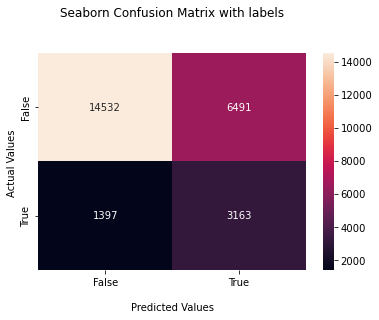

In [11]:
ax = sns.heatmap(cm, annot=True, fmt='')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [101]:
# predicting credit_test.csv file
df_tested = X_test_scaled
df_tested['target'] = model_lgbm.predict(X_test_scaled)
df_tested
df_tested.to_csv('credit_test_predicted.csv')

In [ ]:
# Just evaluating RandomizedSearchCV RandomForest with different evaluation metrics
from sklearn.metrics import accuracy_score

y_hat = rf_random.predict(X_test)
acc = accuracy_score(y_test, y_hat)
print("Accuracy of RandomizedSearchCV RandomForest Classifier:", acc)

#### As final model we will take LightGBM with hyperparameter tuning

In [105]:
with open('lgbm_tuned_model', 'wb') as f3:
  pickle.dump(model_lgbm, f3)